# CAB420 Assignment 2 


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten,Conv2DTranspose, Reshape,Dropout,LSTM
from keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import glob
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = None
from datetime import datetime
import copy

## LSTM Model

In [2]:
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# 读取数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 检查数据集中是否存在NaN值
print("NaN values in each column:")
print(data.isnull().sum())

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# 检查并打印列名，找出实际的 Home 和 Away 列名
print("Column names after filling NaNs:")
print(data.columns)

# 根据实际列名进行 one-hot 编码
home_team_col = 'HomeTeam'
away_team_col = 'AwayTeam'
data = pd.get_dummies(data, columns=[home_team_col, away_team_col])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        # 填充或截断以确保每个组有相同的时间步数
        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        # 确保特征数一致
        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        # 确保 y_group 的特征数一致
        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    # 确保所有时间步的样本数和特征数一致
    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

# 假设最大时间步数为最大的组大小，最大特征数和目标特征数为所有组中最大的特征数
max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

# 创建训练集、验证集和测试集的时间步
X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

# 查看数据集的维度
print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')

print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

# 构建LSTM模型
print("Class distribution in train set:")
print(train_set['FTR'].value_counts())
model = Sequential()
model.add(Input(shape=(max_timesteps, num_features)))
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(num_y_features, activation='softmax')))
# 编译模型，降低学习率
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'],jit_compile=False)

# 增加训练轮数
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

# 评估模型
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)
NaN values in each column:
Div           0
Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
             ..
APSxG/SoT    63
APSxG+/-      0
AWon          0
Alosts        0
AWon%         0
Length: 299, dtype: int64
Column names after filling NaNs:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/4029485232.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 346)
Validation set shape: (114, 10, 346)
Test set shape: (186, 10, 346)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Class distribution in train set:
FTR
H    747
A    562
D    394
Name: count, dtype: int64
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4364 - loss: 0.3648 - val_accuracy: 0.4947 - val_loss: 0.3495
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6253 - loss: 0.3482 - val_accuracy: 0.5702 - val_loss: 0.3453
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6839 - loss: 0.3434 - val_accuracy: 0.6026 - val_loss: 0.3411
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7210 - loss: 0.3465 - val_accuracy: 0.6281 - val_loss: 0.3372
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7153 - loss: 0.3325 - val_accuracy: 0.6535 - val_loss: 0.3335
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7064 - loss: 0.3434 - val_ac

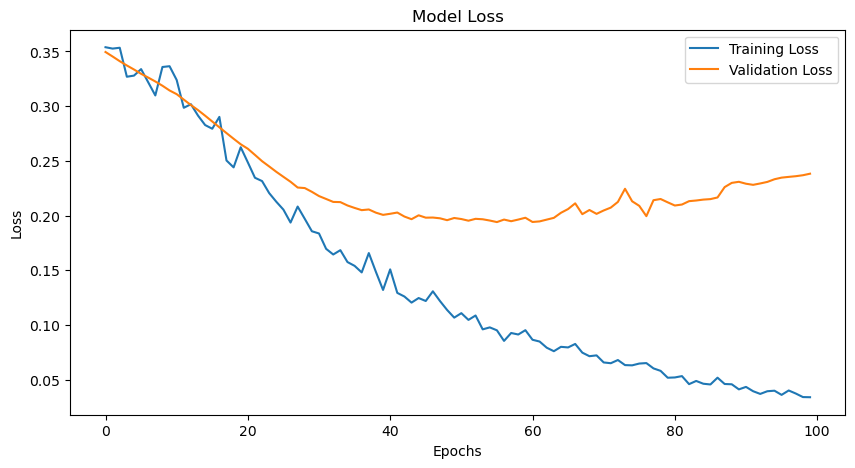

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


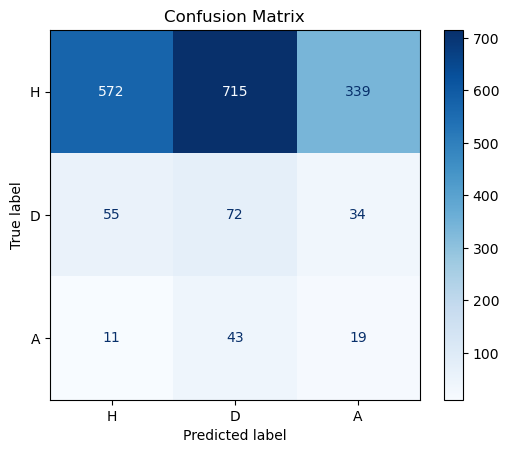

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 训练过程中的损失曲线
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 打印损失曲线
plot_loss(history)

# 计算测试集的预测结果
y_pred = model.predict(X_test)

# 因为y_pred和y_test是one-hot编码的，需要将它们转换为类别标签
y_pred_labels = np.argmax(y_pred, axis=-1).flatten()
y_test_labels = np.argmax(y_test, axis=-1).flatten()

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['H', 'D', 'A'])

# 打印混淆矩阵
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)
NaN values in each column:
Div           0
Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
             ..
APSxG/SoT    63
APSxG+/-      0
AWon          0
Alosts        0
AWon%         0
Length: 299, dtype: int64


/tmp/ipykernel_272975/2189658142.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 346)
Validation set shape: (114, 10, 346)
Test set shape: (186, 10, 346)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4116 - loss: 0.3707 - val_accuracy: 0.6018 - val_loss: 0.3400
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6591 - loss: 0.3437 - val_accuracy: 0.6965 - val_loss: 0.3279
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7214 - loss: 0.3285 - val_accuracy: 0.7123 - val_loss: 0.3178
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7563 - loss: 0.3059 - val_accuracy: 0.7351 - val_loss: 0.3089
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7644 - loss: 0.3031 - val_accuracy: 0.7421 - val_loss: 0.3028
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7585 - loss: 0.2916 - val_accuracy: 0.7553 - val_loss: 0.2971
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accu

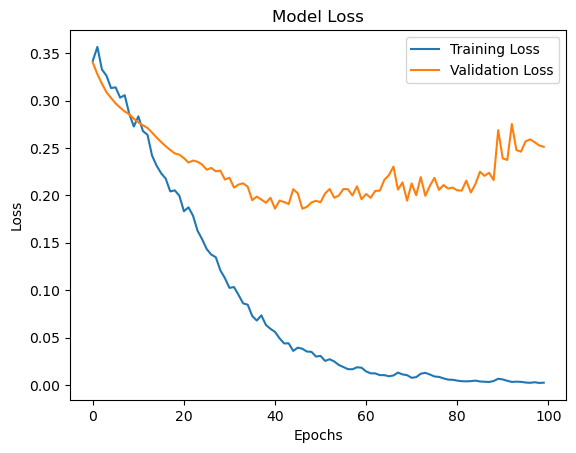

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


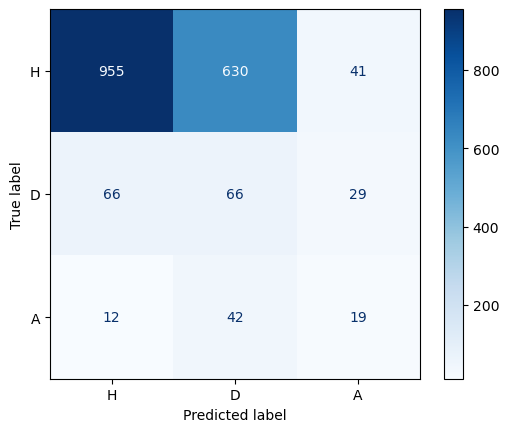

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 检查数据集中是否存在NaN值
print("NaN values in each column:")
print(data.isnull().sum())

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model = Sequential()
model.add(Input(shape=(max_timesteps, num_features)))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(num_y_features, activation='softmax')))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'],jit_compile=False)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/546459432.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 351)
Validation set shape: (114, 10, 351)
Test set shape: (186, 10, 351)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.6993 - loss: 0.3637 - val_accuracy: 0.8535 - val_loss: 0.3494
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8564 - loss: 0.3445 - val_accuracy: 0.8535 - val_loss: 0.3224
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8502 - loss: 0.3235 - val_accuracy: 0.8518 - val_loss: 0.3019
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8458 - loss: 0.3161 - val_accuracy: 0.8386 - val_loss: 0.2964
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8288 - loss: 0.3020 - val_accuracy: 0.8456 - val_loss: 0.2954
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8379 - loss: 0.2978 - val_accuracy: 0.8351 - val_loss: 0.2949
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - ac

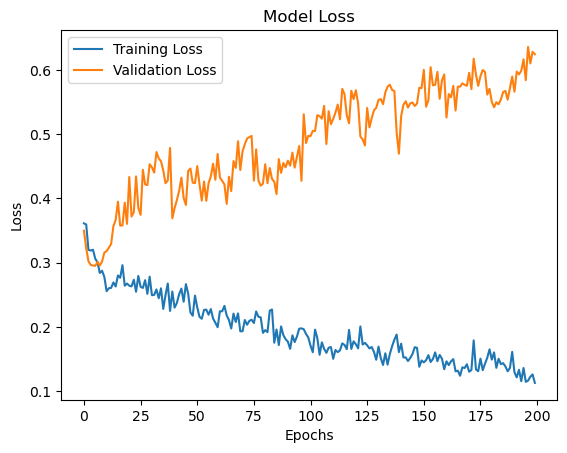

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step


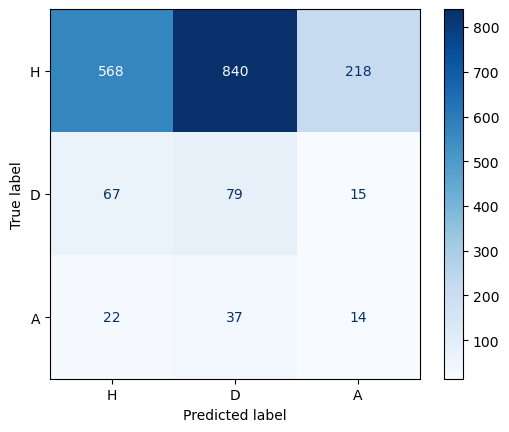

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 增加时间特征
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['Quarter'] = data['Date'].dt.quarter

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model = Sequential()
model.add(Input(shape=(max_timesteps, num_features)))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(num_y_features, activation='softmax')))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'],jit_compile=False)

history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/1456519025.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 351)
Validation set shape: (114, 10, 351)
Test set shape: (186, 10, 351)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4821 - loss: 0.3397 - val_accuracy: 0.7263 - val_loss: 0.3231
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7441 - loss: 0.3164 - val_accuracy: 0.7579 - val_loss: 0.3076
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7656 - loss: 0.3059 - val_accuracy: 0.7877 - val_loss: 0.2987
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7639 - loss: 0.3065 - val_accuracy: 0.7930 - val_loss: 0.2912
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7786 - loss: 0.2854 - val_accuracy: 0.8114 - val_loss: 0.2864
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8023 - loss: 0.2774 - val_accuracy: 0.8175 - val_loss: 0.2829
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accu

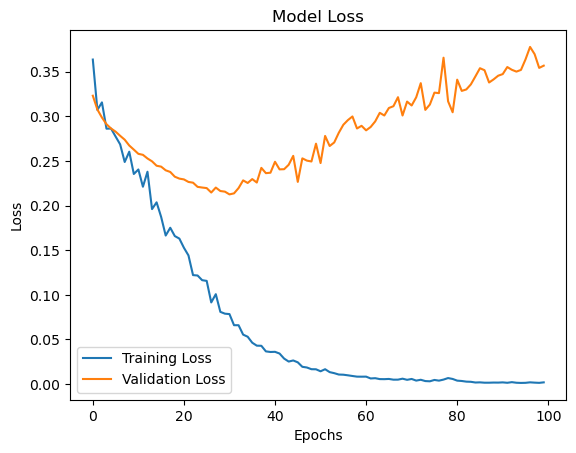

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


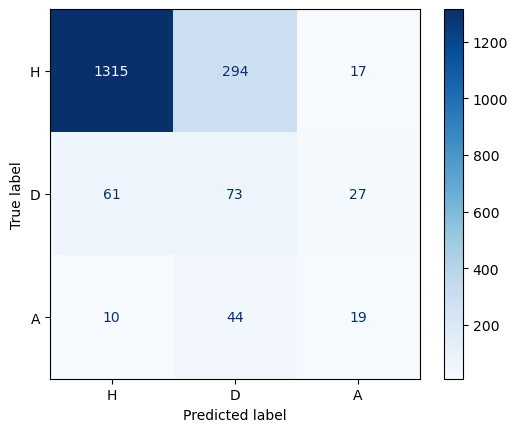

In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 增加时间特征
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['Quarter'] = data['Date'].dt.quarter

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model = Sequential()
model.add(Input(shape=(max_timesteps, num_features)))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(num_y_features, activation='softmax')))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'],jit_compile=False)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LayerNormalization, Dropout, MultiHeadAttention, Layer, Input, Reshape
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 加载数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 增加时间特征
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['Quarter'] = data['Date'].dt.quarter

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Dense(embed_dim)
        self.pos_emb = Dense(embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(tf.expand_dims(positions, 0))
        x = self.token_emb(x)
        return x + positions

embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_timesteps, num_features))
embedding_layer = TokenAndPositionEmbedding(max_timesteps, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(max_timesteps * num_y_features, activation="softmax")(x)
outputs = Reshape((max_timesteps, num_y_features))(x)

model = Model(inputs=inputs, outputs=outputs)

# 在CPU上运行
with tf.device('/CPU:0'):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/3906233977.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 351)
Validation set shape: (114, 10, 351)
Test set shape: (186, 10, 351)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2664 - loss: 0.4353 - val_accuracy: 0.3763 - val_loss: 0.3388
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3770 - loss: 0.3608 - val_accuracy: 0.4640 - val_loss: 0.3213
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4625 - loss: 0.3236 - val_accuracy: 0.5860 - val_loss: 0.3170
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5436 - loss: 0.3282 - val_accuracy: 0.6018 - val_loss: 0.3124
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5379 - loss: 0.3254 - val_accuracy: 0.5588 - val_loss: 0.3112
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5275 - loss: 0.3142 - val_accuracy: 0.6158 - val_loss: 0.3080
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

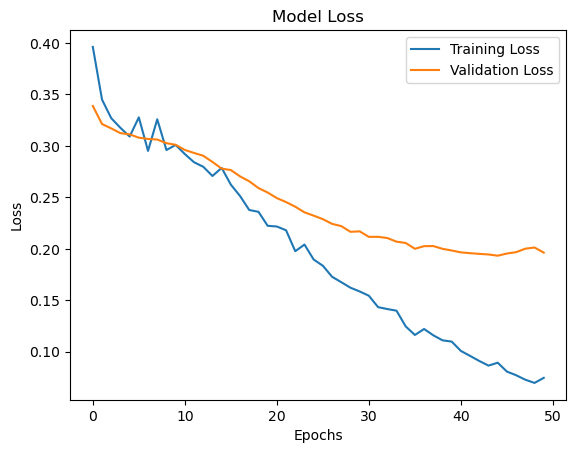

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


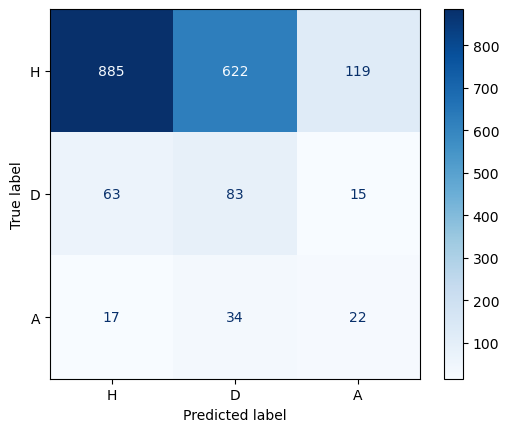

In [9]:
# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/3747055261.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 351)
Validation set shape: (114, 10, 351)
Test set shape: (186, 10, 351)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4471 - loss: 0.3714 - val_accuracy: 0.6816 - val_loss: 0.3272
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7409 - loss: 0.3244 - val_accuracy: 0.7807 - val_loss: 0.3099
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7829 - loss: 0.3078 - val_accuracy: 0.7684 - val_loss: 0.2982
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7971 - loss: 0.2982 - val_accuracy: 0.7956 - val_loss: 0.2924
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8056 - loss: 0.2920 - val_accuracy: 0.8061 - val_loss: 0.2893
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8069 - loss: 0.2841 - val_accuracy: 0.7956 - val_loss: 0.2867
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accu

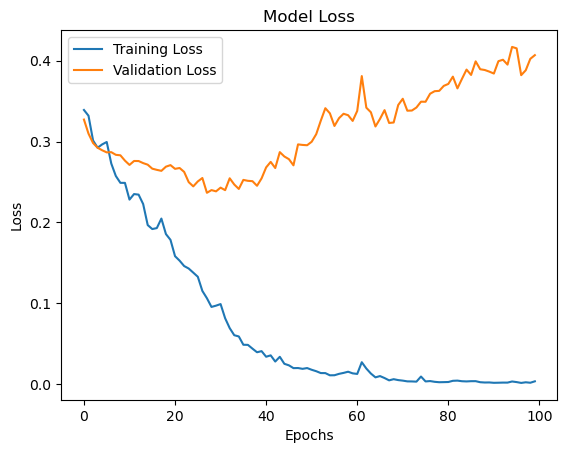

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


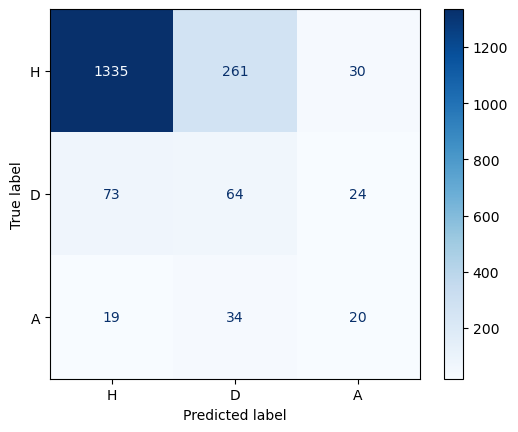

In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 增加时间特征
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['Quarter'] = data['Date'].dt.quarter

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model = Sequential()
model.add(Input(shape=(max_timesteps, num_features)))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(units=300, return_sequences=True)))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(num_y_features, activation='softmax')))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'],jit_compile=False)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/3895352377.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 351)
Validation set shape: (114, 10, 351)
Test set shape: (186, 10, 351)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3669 - loss: 0.4146 - val_accuracy: 0.4982 - val_loss: 0.3237
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4715 - loss: 0.3586 - val_accuracy: 0.5368 - val_loss: 0.3153
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5042 - loss: 0.3280 - val_accuracy: 0.5895 - val_loss: 0.3150
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5153 - loss: 0.3328 - val_accuracy: 0.5737 - val_loss: 0.3093
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5386 - loss: 0.3236 - val_accuracy: 0.5912 - val_loss: 0.3078
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5302 - loss: 0.3152 - val_accuracy: 0.5553 - val_loss: 0.3050
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

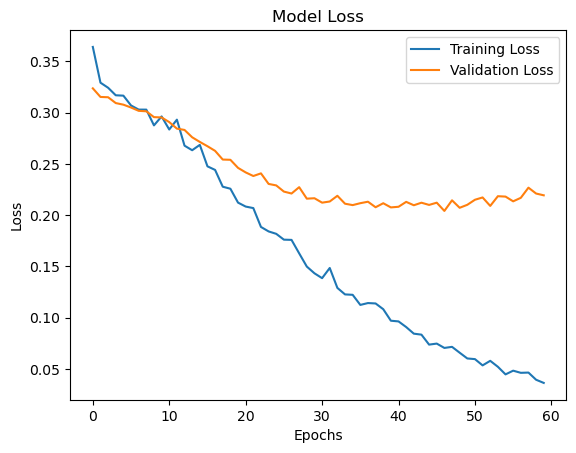

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


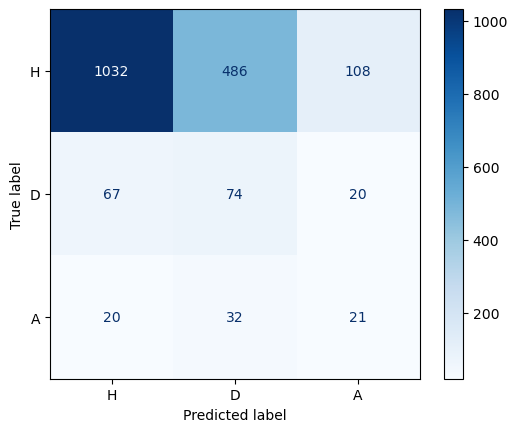

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LayerNormalization, Dropout, MultiHeadAttention, Layer, Input, Reshape
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 加载数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 增加时间特征
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['Quarter'] = data['Date'].dt.quarter

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Dense(embed_dim)
        self.pos_emb = Dense(embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(tf.expand_dims(positions, 0))
        x = self.token_emb(x)
        return x + positions

embed_dim = 64  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_timesteps, num_features))
embedding_layer = TokenAndPositionEmbedding(max_timesteps, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(max_timesteps * num_y_features, activation="softmax")(x)
outputs = Reshape((max_timesteps, num_y_features))(x)

model = Model(inputs=inputs, outputs=outputs)

# 在CPU上运行
with tf.device('/CPU:0'):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

    history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')
# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Column names:
Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AOut', 'AStr', 'AOff', 'Ablock', 'APSxG', 'APSxG/SoT', 'APSxG+/-',
       'AWon', 'Alosts', 'AWon%'],
      dtype='object', length=299)


/tmp/ipykernel_272975/3456416560.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Date'] = dates


Train set shape: (517, 10, 351)
Validation set shape: (114, 10, 351)
Test set shape: (186, 10, 351)
Y Train shape: (517, 10, 3)
Y Validation shape: (114, 10, 3)
Y Test shape: (186, 10, 3)
Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 445ms/step - accuracy: 0.4561 - loss: 0.4075 - val_accuracy: 0.4789 - val_loss: 0.3215
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.5057 - loss: 0.3150 - val_accuracy: 0.5860 - val_loss: 0.3292
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.5532 - loss: 0.3267 - val_accuracy: 0.4614 - val_loss: 0.3165
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - accuracy: 0.4968 - loss: 0.3326 - val_accuracy: 0.6719 - val_loss: 0.3157
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - accuracy: 0.5962 - loss: 0.3194 - val_accuracy: 0.5544 - val_loss: 0.3160
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.5600 - loss: 0.3264 - val_accuracy: 0.7491 - val_loss: 0.3182
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 42

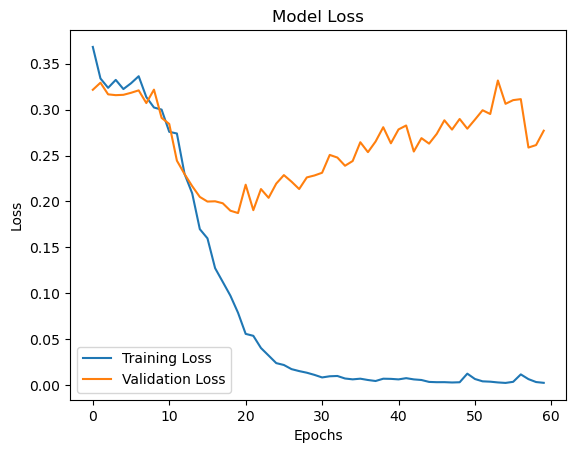

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


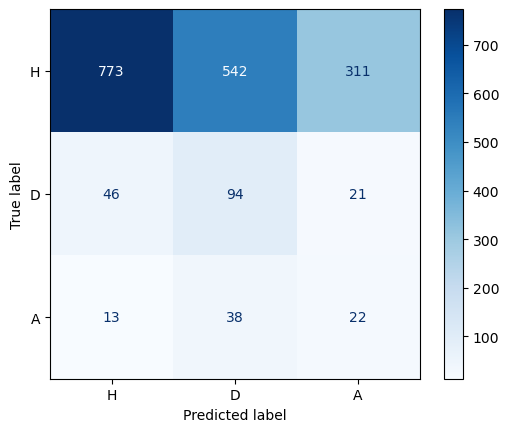

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LayerNormalization, Dropout, MultiHeadAttention, Layer, Input, Reshape
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 加载数据
data = pd.read_csv("Cleaned_Historical_Data_2.csv")

# 打印列名
print("Column names:")
print(data.columns)

# 将 Date 列转换为 datetime 类型
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# 增加时间特征
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['Quarter'] = data['Date'].dt.quarter

# 填充NaN值
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# one-hot 编码
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'])

# 移除 Date 列以进行标准化
dates = data.pop('Date')

# 标准化输入数据
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 重新添加 Date 列
data['Date'] = dates

# 分割数据集
train_set = data[data['Date'].dt.year < 2022]
val_set = data[data['Date'].dt.year == 2022]
test_set = data[data['Date'].dt.year > 2022]

# 要删除的列
columns_to_drop = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# 创建目标变量 Y
def create_target(data):
    y = data['FTR'].map({"H": 0, "D": 1, "A": 2})
    return pd.get_dummies(y)

# 按天分组并构建时间步
def create_time_steps(data, max_timesteps, num_features, num_y_features):
    grouped = data.groupby(data['Date'].dt.date)
    X_list = []
    y_list = []

    for date, group in grouped:
        X_group = group.drop(columns=columns_to_drop).values
        y_group = create_target(group).values

        if X_group.shape[0] < max_timesteps:
            padding_length = max_timesteps - X_group.shape[0]
            X_group = np.pad(X_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
            y_group = np.pad(y_group, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        elif X_group.shape[0] > max_timesteps:
            X_group = X_group[:max_timesteps, :]
            y_group = y_group[:max_timesteps, :]

        if X_group.shape[1] < num_features:
            padding_length = num_features - X_group.shape[1]
            X_group = np.pad(X_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif X_group.shape[1] > num_features:
            X_group = X_group[:, :num_features]

        if y_group.shape[1] < num_y_features:
            padding_length = num_y_features - y_group.shape[1]
            y_group = np.pad(y_group, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
        elif y_group.shape[1] > num_y_features:
            y_group = y_group[:, :num_y_features]

        X_list.append(X_group)
        y_list.append(y_group)

    X_array = np.array(X_list, dtype=np.float32)
    y_array = np.array(y_list, dtype=np.float32)

    return X_array, y_array

max_timesteps = train_set.groupby(train_set['Date'].dt.date).size().max()
num_features = train_set.drop(columns=columns_to_drop).shape[1]
num_y_features = create_target(train_set).shape[1]

X_train, y_train = create_time_steps(train_set, max_timesteps, num_features, num_y_features)
X_val, y_val = create_time_steps(val_set, max_timesteps, num_features, num_y_features)
X_test, y_test = create_time_steps(test_set, max_timesteps, num_features, num_y_features)

print(f'Train set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Y Train shape: {y_train.shape}')
print(f'Y Validation shape: {y_val.shape}')
print(f'Y Test shape: {y_test.shape}')

train_targets_single = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets_single), y=train_targets_single)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Dense(embed_dim)
        self.pos_emb = Dense(embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(tf.expand_dims(positions, 0))
        x = self.token_emb(x)
        return x + positions

embed_dim = 256  # Embedding size for each token
num_heads = 12  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_timesteps, num_features))
embedding_layer = TokenAndPositionEmbedding(max_timesteps, embed_dim)
x = embedding_layer(inputs)
for _ in range(4):
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
x = transformer_block(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(max_timesteps * num_y_features, activation="softmax")(x)
outputs = Reshape((max_timesteps, num_y_features))(x)

model = Model(inputs=inputs, outputs=outputs)

# 在CPU上运行
with tf.device('/CPU:0'):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

    history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')
# 绘制loss图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 预测并计算混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_test, axis=-1).flatten()

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.show()